In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA
import argparse
from scutils import best_response
from scutils import SC_solver, OperatorSC
import scipy.linalg  as sla
from cf_matrix import make_confusion_matrix as mkcfmat
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate data
we used seeds 6 and 27 in the figures in the paper. The choice of the seed impacts the observations we make of course. 


In [212]:
N = 1000
N_test = 100
# Set the dimension
d = 2
seed= 6 #980 #  6 27
np.random.seed(seed) #10, (8,100)


# Generate training data matrix X_train
X_f = np.random.randn(N, d)
One = np.ones((N,1))
X_full = np.append(X_f,One,axis=1)

# Generate ground truth theta_ground_truth
theta_ground_truth = np.random.randn(d+1, 1)

# X_full = np.random.randn(N, d)
# Generate outputs y_train
Y_full = (np.sign(X_full@ theta_ground_truth + 0.1 * np.random.randn(N, 1))+1)/2

if len(np.where(Y_full==0.0)[0])>=len(np.where(Y_full==1.0)[0]):
    nzero=len(np.where(Y_full==1.0)[0])
    w=1.0
    
else:
    nzero=len(np.where(Y_full==0.0)[0])
    print(nzero)
    w=0.0

#X_full[np.where(Y_full==1.0)[0][0:nzero]]
X_full_=np.vstack((X_full[np.where(Y_full==1.0)[0][0:nzero]], X_full[np.where(Y_full==0.0)[0][0:nzero]]))
Y_full_=np.vstack((Y_full[np.where(Y_full==1.0)[0][0:nzero]], Y_full[np.where(Y_full==0.0)[0][0:nzero]]))

# Generate training data matrix X_train
X_testT = np.random.randn(N_test, d)
OneT = np.ones((N_test,1))
X_test = np.append(X_testT,OneT,axis=1)
# Generate outputs y_train
y_test = (np.sign(X_test@ theta_ground_truth + 0.1 * np.random.randn(N_test, 1))+1)/2

strat_features = np.array([1,2]) - 1
print(strat_features)
#strat_features=[]
# One = np.ones((N,1))
bal=len(np.where(Y_full_==0.0)[0])
print(bal)
X_test=np.vstack((X_full_[0:50], X_full_[bal:bal+50]))
y_test=np.vstack((Y_full_[0:50], Y_full_[bal:bal+50]))

X_train=np.vstack((X_full_[50:bal], X_full_[bal+50:len(Y_full_)]))
y_train=np.vstack((Y_full_[50:bal], Y_full_[bal+50:len(Y_full_)]))
# X_full = np.append(X_f,One,axis=1)
N_train=int(bal*2-N_test)

# split into 2/3-1/3
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full_, Y_full_, test_size=0.33)
N_train=len(y_train)
N_test=len(y_test)

[0 1]
446


In [213]:
# Plotting the classifier 
def classifier_line(theta_FO, bdd=(-1,1)):
    numPoints = 100
    X1_classifier = np.linspace(bdd[0],bdd[1],numPoints)
    X2_classifier = np.zeros((numPoints,1))
    ratio = -theta_FO[0]/theta_FO[1]
    for j in range(numPoints):
        X2_classifier[j] = (-theta_FO[2]-theta_FO[0]*X1_classifier[j])/theta_FO[1]
    return X1_classifier,X2_classifier

#X1_Robust,X2_Robust=classifier_plotter(theta_FO) 



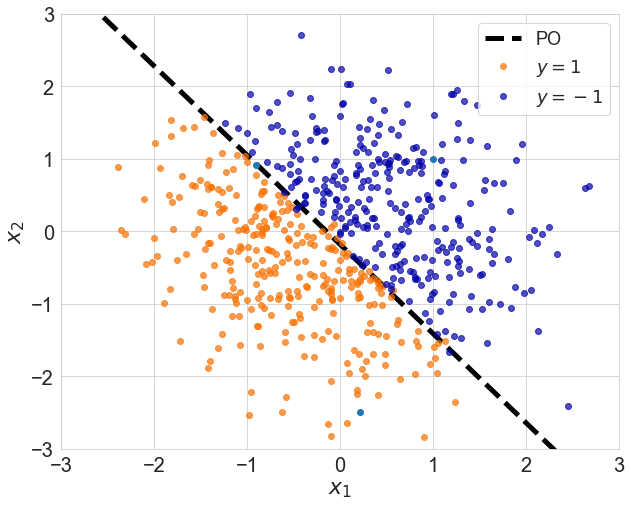

In [214]:
# Plot the ground truth data distribution

        
X_test_=X_train #best_response(X_train ,2*y_train.reshape((N_train, 1))-1,theta_ground_truth, strat_features=strat_features,zeta=zeta)


Xp = X_test_[np.where(y_train==1)[0],0]
Yp = X_test_[np.where(y_train==1)[0],1]
Xm = X_test_[np.where(y_train==0)[0],0]
Ym = X_test_[np.where(y_train==0)[0],1]
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
X1_PO, X2_PO=classifier_line(theta_ground_truth, bdd=(-3,3))
plt.plot(X1_PO,X2_PO, label='PO', color='xkcd:black', linewidth=5, linestyle='--')
plt.plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', label=r'$y=1$', alpha=0.7)
plt.plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', label=r'$y=-1$', alpha=0.7)
plt.plot(X_full_[0], X_full_[1],'.', markersize=12)
plt.tick_params(labelsize=20)
plt.xlabel(r'$x_1$', fontsize=22)
plt.ylabel(r'$x_2$', fontsize=22)
plt.legend(fontsize=18)
plt.xlim([-3,3])
plt.ylim([-3,3])
for tag in ['png','pdf']:
    plt.savefig('seed={}_original_final.'.format(seed)+tag, transparent=True, dpi=300, bbox_inches='tight')

In [215]:
def compute_Psi_g(z):
    
    psi = 2*np.log(np.exp(z)+1) - z
    return psi 

def best_response_g(X,Y, theta1,theta2, strat_features=[], noise=0, scale=0, zeta = [0.001,0.001]):
    
    n,d = X.shape
    X_strat = np.copy(X)
    zeta1,zeta2=zeta
    theta_vec1 = theta1.reshape((1,d))
    theta_vec2 = theta2.reshape((1,d))
    theta_strat1 = theta_vec1[0, strat_features]
    theta_strat2 = theta_vec2[0, strat_features]
    for j in range(n):    
        if Y[j] == -1:
            X_strat[j, strat_features] += zeta1 * theta_strat1 + zeta2*theta_strat2
    return X_strat

def evaluate_hi_g(X, Y, theta,theta_other, strat_features = [], noise = 0, scale = 0, zeta= [0.001,0.001]):
    # Evaluate hi function, which returns (best response features)^T theta.

    X_perf = best_response_g(X,Y, theta,theta_other, strat_features=strat_features, noise=noise, scale=scale, zeta=zeta)
    #print(np.shape(X_perf), "xperf")
    return X_perf @ theta

def evaluate_logreg_loss_game(X,y,theta,theta_other,strat_features,zeta,reg_factor = 0):
    #Compute the  best response 
    hi_theta =  evaluate_hi_g(X, y, theta,theta_other, strat_features = strat_features, zeta = zeta)
    
    loss_1 = (1.0 / X.shape[0]) * np.sum(compute_Psi_g(hi_theta))
    factor = y*hi_theta
    loss_2 = (1.0 / X.shape[0])* np.sum(factor)
    loss_reg = reg_factor*np.linalg.norm(theta)**2
    return loss_1-loss_2+loss_reg

def gradient_Psi(z):

    psi_grad = (2*np.exp(z))/(1+np.exp(z)) - 1
    return psi_grad 

def hessian_Psi(z):

    psi_hess = (2*np.exp(z))/((1+np.exp(z))**2)
    return psi_hess

def CheckNash(X_,y_,theta1,theta2,strat_features = [],zeta1=[0.001,0.001],zeta2=[0.001,0.001],reg_factor = 0, dynamic=False, mixing=0, n_epoch=0, X_base=None ):
    print("First Order Conditions:")
    print(OperatorSC_game(X_, y_,theta1,theta2,strat_features = strat_features,zeta=zeta1,reg_factor = reg_factor))
    print(OperatorSC_game(X_, y_,theta2,theta1,strat_features = strat_features,zeta=zeta2,reg_factor = reg_factor))  
    n,d = X_.shape
    X_strat1 = np.copy(X_)
    theta_vec = theta1.reshape((1,d))
    theta_vec_other = theta2.reshape((1,d))
    inter_1 = theta_vec[0,strat_features].reshape((len(strat_features),))
    inter_1_other = theta_vec_other[0,strat_features].reshape((len(strat_features),))
    for j in range(n):
        if y_[j] == -1:
            X_strat1[j, strat_features] += 2*zeta1[0] * inter_1 +1*zeta1[1]*inter_1_other
    hi_theta = evaluate_hi_g(X_, y_, theta1,theta2, strat_features=strat_features,zeta=zeta1)
    XX=2*np.ones(np.shape(X_strat1.transpose()))
    print(XX)
    h1=(1/n)*X_strat1.transpose() @ (np.diag(hessian_Psi(hi_theta).flatten())@X_strat1)+2*reg_factor+ 1/n*XX@ (gradient_Psi(hi_theta) - y_)
    print("hessian player 1 :\n", LA.eigvals(h1))
    X_strat2 = np.copy(X_)
    theta_vec = theta2.reshape((1,d))
    theta_vec_other = theta1.reshape((1,d))
    inter_1 = theta_vec[0,strat_features].reshape((len(strat_features),))
    #print("inter 1: ", np.shape(inter_1))
    inter_1_other = theta_vec_other[0,strat_features].reshape((len(strat_features),))
    for j in range(n):
        if y_[j] == -1:
            X_strat2[j, strat_features] += 2*zeta2[0] * inter_1 +1*zeta2[1]*inter_1_other
    hi_theta = evaluate_hi_g(X_, y_, theta2,theta1, strat_features=strat_features,zeta=zeta2)
    print(np.shape(hi_theta))
    print(np.shape(gradient_Psi(hi_theta)))
    XX=2*np.ones(np.shape(X_strat2.transpose()))
    h2=(1/n)*X_strat2.transpose() @ (np.diag(hessian_Psi(hi_theta).flatten())@X_strat2)+2*reg_factor+ 1/n*XX@ (gradient_Psi(hi_theta) - y_)
    
    print("hessian player 2 :\n", LA.eigvals(h2))
    
def OperatorSC_game(X_, y_,theta,theta_other,strat_features = [],zeta=[0.001,0.001],reg_factor = 0, dynamic=False, mixing=0, n_epoch=0, X_base=None):
    # Always input Y as swapped 
    n,d = X_.shape
    #Pseudo Code : 
        # Compute the gradient of logistic loss with respect to theta:
            # Important to note that if Y=
    ######## Note that I am putting negative y here because of labelling issues 
    hi_theta = evaluate_hi_g(X_, y_, theta,theta_other, strat_features=strat_features,zeta=zeta)
    X_strat = np.copy(X_)
    X_BR = np.copy(X_)
    theta_vec = theta.reshape((1,d))
    theta_vec_other = theta_other.reshape((1,d))
    
    inter_1 = theta_vec[0,strat_features].reshape((len(strat_features),))
    inter_1_other = theta_vec_other[0,strat_features].reshape((len(strat_features),))
    
    for j in range(n):
        if y_[j] == -1:
            X_strat[j, strat_features] += 2*zeta[0] * inter_1 +1*zeta[1]*inter_1_other

    inter_2 = gradient_Psi(hi_theta)
    F_theta_reg = 2*reg_factor*theta
    inter_3 = y_
    #X_true_grad = (1/n)*X_strat.transpose() @ (inter_2 - inter_3) + F_theta_reg
    X_true_grad = (1/n)*X_strat.transpose() @ (inter_2 - inter_3) + F_theta_reg
    #print("n :", n)
    #print("shape theta_vec", np.shape(theta_vec))
    for i in range(3):
        temp=0
        for j in range(n):
            if y_[j] == -1:
                temp+=-np.exp(y_[j]*hi_theta[j])*y_[j]*(X_[j,i]+2*theta_vec[0,i]*zeta[0]+1*theta_vec_other[0,i]*zeta[1])/(1+np.exp(y_[j]*hi_theta[j]))
        X_true_grad[i] = (1/n)*np.sum(temp)
    #print("shape X_strat : ", np.shape(X_strat.transpose()))
    #print("shape inter_2 : ", np.shape(inter_2))
    return X_true_grad
    
    
def SC_solver_game(X_train, y_train,zeta=[[0.01,0.01],[0.01,0.01]], eta=0.001, NUM_EPOCHS=100, strat_features = [],
              u_init_1=[],u_init_2=[],divide=1,factor_eta= 1,avg_factor=0.5,reg_factor = 0, dynamic=False, mixing=0, n_epoch=0, loc=1.0, scale=1.0, seed=0, 
              theta_gt=None):
    #  Using GD method to solve for PP problem of strategic classificaiton 
    #print('X_train shape: ', X_train.shape)
    #print('y_train shape: ', y_train.shape)
    #print('y values: ', np.unique(y_train))
    np.random.seed(seed)
    #print('====================================')
    eta_init = np.copy(eta)
    n,d = X_train.shape
    theta_lst_1  = []
    theta_lst_2  = []
    loss_lst_1 = []
    loss_lst_2 = []
    X_train_dynamic_all=[]
    if len(u_init_1) == 0:
        theta_init_1 = 0*np.ones((d,1))
    else: 
        theta_init_1 = u_init_1[0]
    if len(u_init_2) == 0:
        theta_init_2 = 0*np.ones((d,1))
    else: 
        theta_init_2 = u_init_2[0]
    theta_lst_1.append(theta_init_1)
    theta_lst_2.append(theta_init_2)
    zeta1=zeta[0]
    zeta2=zeta[1]
    loss_init_1 = evaluate_logreg_loss_game(X_train,y_train,theta_init_1,theta_init_2,strat_features,zeta1,reg_factor=reg_factor)
    loss_lst_1.append(loss_init_1) 
    loss_init_2 = evaluate_logreg_loss_game(X_train,y_train,theta_init_2,theta_init_1,strat_features,zeta2,reg_factor=reg_factor)
    loss_lst_2.append(loss_init_2) 
    

    u1 = np.copy(theta_init_1)
    u2 = np.copy(theta_init_2)
    loss_prev_1 = np.copy(loss_init_1)
    loss_prev_2 = np.copy(loss_init_2)
    for j in range(NUM_EPOCHS):
        grad_theta_1 = OperatorSC_game(X_train, y_train,u1,u2,strat_features = strat_features,zeta=zeta1,reg_factor=reg_factor, 
                                dynamic=dynamic)
        grad_theta_2 = OperatorSC_game(X_train, y_train,u2,u1,strat_features = strat_features,zeta=zeta2,reg_factor=reg_factor, 
                                dynamic=dynamic)
        u1 = np.copy(u1 - eta*grad_theta_1)
        u2 = np.copy(u2 - eta*grad_theta_2)
        theta_lst_1.append(u1)
        theta_lst_2.append(u2)
        loss1 = evaluate_logreg_loss_game(X_train,y_train,u1,u2,strat_features,zeta1,reg_factor=reg_factor)
        loss2 = evaluate_logreg_loss_game(X_train,y_train,u2,u1,strat_features,zeta2,reg_factor=reg_factor)
        loss_lst_1.append(loss1)
        loss_lst_2.append(loss2)
        #if j%100 == 1:
        #    print('PP Problem eta ', eta)
        #if j>0.5*EPOCH :
        #    eta = eta_init*0.5
        loss_prev_1 = np.copy(loss1)
        loss_prev_2 = np.copy(loss2)
    
    theta_final_1 = np.copy(u1)
    theta_final_2 = np.copy(u2)
    loss_final_1 = np.copy(loss1)
    loss_final_2 = np.copy(loss2)

    return theta_final_1,theta_final_2,loss_final_1,loss_final_2,theta_lst_1,theta_lst_2,loss_lst_1,loss_lst_2

In [217]:

reg_factor = 1/N_train
print("reg factor: ", reg_factor)
u_init = []
epochs_PP = 15000
N = len(Y_full_)


zeta = 0.1  # Power of best response of agent 

zeta = [[0.1,0],
        [0,0.0]]
reg_factor=1/np.shape(X_train)[0]
M=2*np.linalg.norm(X_train)/np.shape(X_train)[0]+2*reg_factor*1000 # R=1000 is the bound on Theta
eta_init_PP = 1/M
print(eta_init_PP)

# performative optimal point
theta_nash_1,theta_nash_2,loss_nash_1,loss_nash_2,theta_lst_1,theta_lst_2,loss_lst_1,loss_lst_2 = SC_solver_game(X_train,
                                                                    2*y_train.reshape((N_train, 1))-1,zeta=zeta, 
                                                        eta=eta_init_PP, NUM_EPOCHS=epochs_PP, strat_features = strat_features,
                                                        u_init_1=u_init,u_init_2=u_init, reg_factor=reg_factor, theta_gt=theta_ground_truth)

CheckNash(X_train, 2*y_train.reshape((N_train, 1))-1,theta_final_1,theta_final_2,strat_features = strat_features,zeta1=zeta[0],zeta2=zeta[1],reg_factor = reg_factor)

reg factor:  0.0016750418760469012
0.286602108390558


<ipython-input-215-92f0ab048160>:113: RuntimeWarning: overflow encountered in multiply
  temp+=-np.exp(y_[j]*hi_theta[j])*y_[j]*(X_[j,i]+2*theta_vec[0,i]*zeta[0]+1*theta_vec_other[0,i]*zeta[1])/(1+np.exp(y_[j]*hi_theta[j]))
<ipython-input-215-92f0ab048160>:17: RuntimeWarning: invalid value encountered in multiply
  X_strat[j, strat_features] += zeta1 * theta_strat1 + zeta2*theta_strat2
<ipython-input-215-92f0ab048160>:3: RuntimeWarning: invalid value encountered in subtract
  psi = 2*np.log(np.exp(z)+1) - z
/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-215-92f0ab048160>:100: RuntimeWarning: invalid value encountered in multiply
  X_strat[j, strat_features] += 2*zeta[0] * inter_1 +1*zeta[1]*inter_1_other
<ipython-input-215-92f0ab048160>:113: RuntimeWarning: invalid value encountered in double_scalars
  temp+=-np.exp(y_[j]*hi_theta[j])*y_[j]

First Order Conditions:
[[0.10562755]
 [0.06481021]
 [0.34144252]]
[[0.27641191]
 [0.19806381]
 [0.44114603]]
[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
hessian player 1 :
 [-0.49104381  0.30183344  0.34614799]
(597, 1)
(597, 1)
hessian player 2 :
 [-0.8944524   0.25808839  0.28225294]


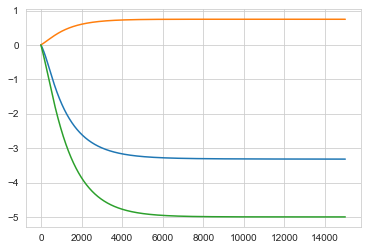

In [210]:
theta_vals_1=np.asarray(theta_lst_1)
for i in range(3):
    plt.plot(theta_vals_1[:,i])

In [211]:
theta_final_1, theta_final_2

(array([[-1.97728252],
        [-1.57336258],
        [-0.78076072]]),
 array([[-1.97728252],
        [-1.57336258],
        [-0.78076072]]))

In [148]:
loss_nash_1, loss_nash_2

(array(0.82156726), array(0.15219043))

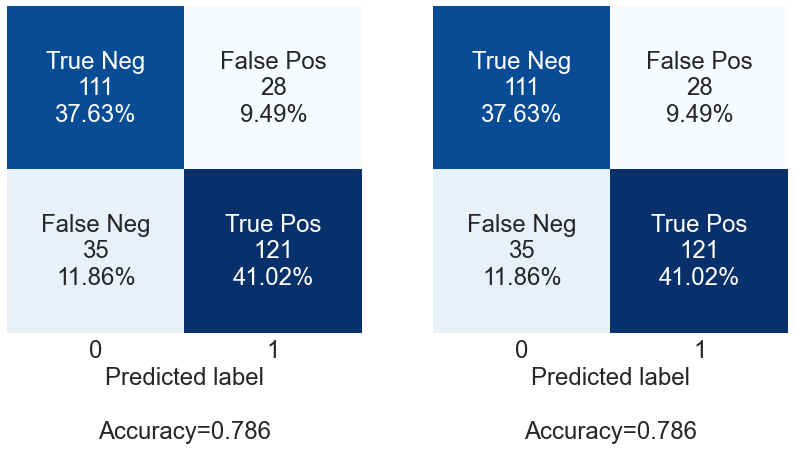

In [125]:
theta_final_g=[theta_final_1,theta_final_2]
for n_epoch in [epochs_PP]:
    fig,ax=plt.subplots(nrows=1,ncols=2, figsize=(14,6))
    for i,(thetas,zetas) in enumerate(zip(theta_final_g, zeta)):
        if i==1:
            X_perf = best_response_g(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final_g[1],theta_final_g[0], strat_features=strat_features,zeta=zetas)
        else:
            X_perf = best_response_g(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final_g[i],theta_final_g[i+1], strat_features=strat_features,zeta=zetas)
        cf_matrix=confusion_matrix((X_perf.dot(thetas) > 0),y_test)

        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in
                        cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                  zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        mkcfmat(cf_matrix,group_names=group_names, verbose=False, ax=ax[i])

        


### with competition


In [152]:
reg_factor

0.0016750418760469012

In [146]:
reg_factor = 1000/N_train
u_init = []
epochs_PP = 20000
N = len(Y_full_)


zeta = 0.1  # Power of best response of agent 

zeta = [[0.2,0.01],
        [-0.1,0.2]]
reg_factor=1/np.shape(X_train)[0]
M=2*np.linalg.norm(X_train)/np.shape(X_train)[0]+2*reg_factor*1000 # R=1000 is the bound on Theta
eta_init_PP = 0.1/M
print(eta_init_PP)

# performative optimal point
theta_nash_1,theta_nash_2,loss_nash_1,loss_nash_2,theta_lst_1,theta_lst_2,loss_lst_1,loss_lst_2 = SC_solver_game(X_train,
                                                                    2*y_train.reshape((N_train, 1))-1,zeta=zeta, 
                                                        eta=eta_init_PP, NUM_EPOCHS=epochs_PP, strat_features = strat_features,
                                                        u_init_1=u_init,u_init_2=u_init, reg_factor=reg_factor, theta_gt=theta_ground_truth)

CheckNash(X_train, 2*y_train.reshape((N_train, 1))-1,theta_final_1,theta_final_2,strat_features = strat_features,zeta1=zeta[0],zeta2=zeta[1],reg_factor = reg_factor)

0.028660210839055802
First Order Conditions:
[[-0.06773672]
 [-0.05466918]
 [ 0.01046796]]
[[ 0.13965811]
 [ 0.11808682]
 [-0.09486444]]
[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
hessian player 1 :
 [0.12084975 0.33905281 0.45623333]
(597, 1)
hessian player 2 :
 [-0.42295143  0.27868681  0.31538348]


In [149]:
theta_final_1, theta_final_2

(array([[-1.97728252],
        [-1.57336258],
        [-0.78076072]]),
 array([[-1.97728252],
        [-1.57336258],
        [-0.78076072]]))

In [150]:
loss_nash_1, loss_nash_2

(array(0.82156726), array(0.15219043))

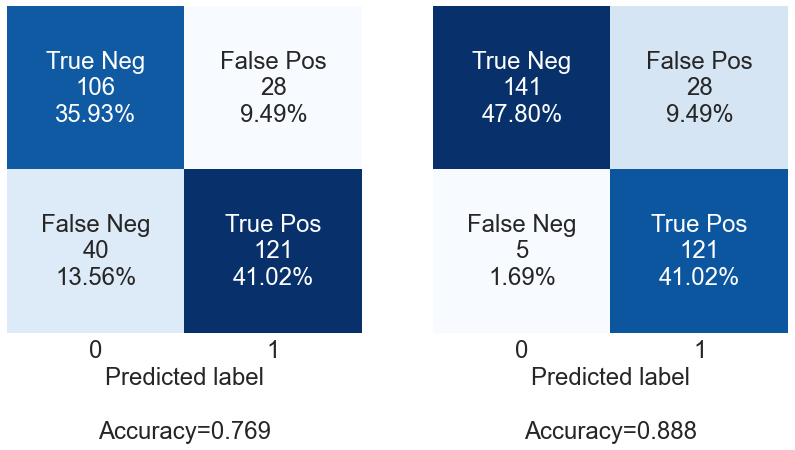

In [151]:
theta_final_g=[theta_final_1,theta_final_2]
for n_epoch in [epochs_PP]:
    fig,ax=plt.subplots(nrows=1,ncols=2, figsize=(14,6))
    for i,(thetas,zetas) in enumerate(zip(theta_final_g, zeta)):
        if i==1:
            X_perf = best_response_g(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final_g[1],theta_final_g[0], strat_features=strat_features,zeta=zetas)
        else:
            X_perf = best_response_g(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final_g[i],theta_final_g[i+1], strat_features=strat_features,zeta=zetas)
        cf_matrix=confusion_matrix((X_perf.dot(thetas) > 0),y_test)

        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in
                        cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                  zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        mkcfmat(cf_matrix,group_names=group_names, verbose=False, ax=ax[i])

        


In [ ]:
theta_final_all_p2={}
theta_final_all_p1={}
classifiers={}
losses={}

n_epochs=[1000]
for n_epoch in n_epochs:

    theta_final_d, loss_final_d, theta_lst_d,loss_lst_d, X_train_dynamic_all = SC_solver(X_train,2*y_train.reshape((N_train, 1))-1,zeta=zeta,mixing=mixing,
                                                                                             n_epoch=n_epoch, eta=eta_init_PP, 
                                                                    EPOCH=epochs_PP, strat_features = strat_features,u_init=u_init,reg_factor=reg_factor,
                                                                    dynamic=True, loc=1.0, scale=45.0, seed=seed, theta_gt=theta_ground_truth.T) #45
    theta_final_all[(mixing,n_epoch)]=theta_final_d
    X1_PP, X2_PP = classifier_line(theta_final_d, bdd=(-3,3))
    classifiers[(mixing,n_epoch)]=(X1_PP,X2_PP)
    losses[(mixing,n_epoch)]=loss_lst_d
    print("theta final : ", theta_final_d.T)
    print()

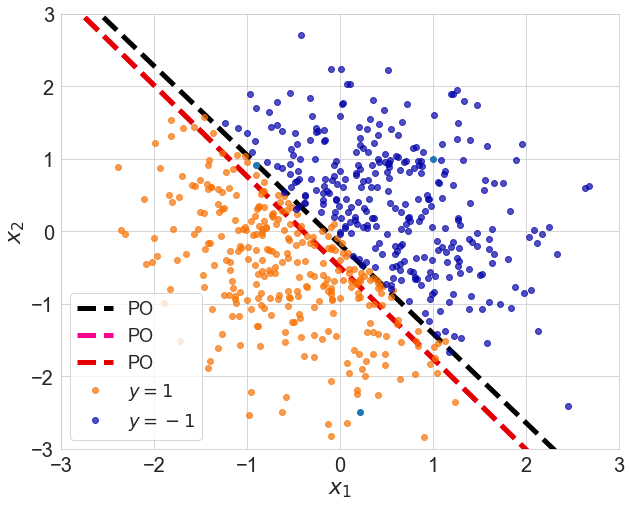

In [95]:
# Plot the ground truth data distribution

        
X_test_=X_train #best_response(X_train ,2*y_train.reshape((N_train, 1))-1,theta_ground_truth, strat_features=strat_features,zeta=zeta)


Xp = X_test_[np.where(y_train==1)[0],0]
Yp = X_test_[np.where(y_train==1)[0],1]
Xm = X_test_[np.where(y_train==0)[0],0]
Ym = X_test_[np.where(y_train==0)[0],1]
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
X1_PO, X2_PO=classifier_line(theta_ground_truth, bdd=(-3,3))
plt.plot(X1_PO,X2_PO, label='PO', color='xkcd:black', linewidth=5, linestyle='--')

X1_PO, X2_PO=classifier_line(theta_nash_1, bdd=(-3,3))
plt.plot(X1_PO,X2_PO, label='PO', color='xkcd:hot pink', linewidth=5, linestyle='--')

X1_PO, X2_PO=classifier_line(theta_nash_2, bdd=(-3,3))
plt.plot(X1_PO,X2_PO, label='PO', color='xkcd:red', linewidth=5, linestyle='--')

plt.plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', label=r'$y=1$', alpha=0.7)
plt.plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', label=r'$y=-1$', alpha=0.7)
plt.plot(X_full_[0], X_full_[1],'.', markersize=12)
plt.tick_params(labelsize=20)
plt.xlabel(r'$x_1$', fontsize=22)
plt.ylabel(r'$x_2$', fontsize=22)
plt.legend(fontsize=18)
plt.xlim([-3,3])
plt.ylim([-3,3])
for tag in ['png','pdf']:
    plt.savefig('seed={}_original_final.'.format(seed)+tag, transparent=True, dpi=300, bbox_inches='tight')

In [111]:
reg_factor = 1/N_train
u_init = []
epochs_PP = 5000
N = len(Y_full_)


zeta = 0.02  # Power of best response of agent 

zeta = zeta
reg_factor=1/np.shape(X_train)[0]
M=2*np.linalg.norm(X_train)/np.shape(X_train)[0]+2*reg_factor*1000 # R=1000 is the bound on Theta
eta_init_PP = 5/M

# performative optimal point
theta_final, loss_final, theta_lst,loss_lst = SC_solver(X_train,2*y_train.reshape((N_train, 1))-1,zeta=zeta, 
                                                        eta=eta_init_PP, EPOCH=epochs_PP, strat_features = strat_features,
                                                        u_init=u_init,reg_factor=reg_factor, theta_gt=theta_ground_truth)
print(theta_final)
print(loss_final)
print(OperatorSC(X_train,2*y_train.reshape((N_train, 1))-1,theta_final,zeta=zeta, reg_factor=reg_factor))

[[-4.38232029]
 [-3.56492874]
 [-0.71150037]]
0.3686711311172931
[[ 0.01487051]
 [ 0.01658961]
 [-0.04393327]]


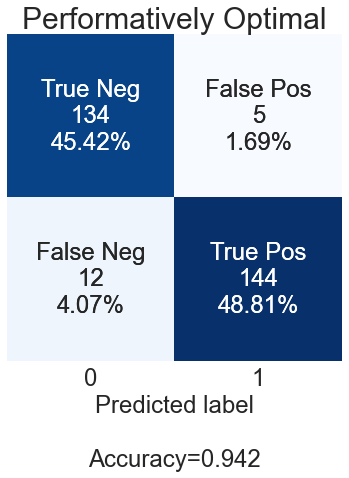

In [116]:
for n_epoch in [epochs_PP]:
    fig,ax=plt.subplots(nrows=1,ncols=1, figsize=(6,6))
    for i,mixing in enumerate([1]):
        
        X_perf = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final, strat_features=strat_features,zeta=zeta)
        cf_matrix=confusion_matrix((X_perf.dot(theta_final) > 0),y_test)

        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in
                        cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                  zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        mkcfmat(cf_matrix,group_names=group_names, verbose=False, ax=ax)
        ax.set_title(r'($\delta$, $n$)=({},{})'.format(mixing,n_epoch), fontsize=30)
        
    X_perf = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final, strat_features=strat_features,zeta=zeta)
    cf_matrix=confusion_matrix((X_perf.dot(theta_final) > 0),y_test)
    mkcfmat(cf_matrix,group_names=group_names, verbose=False, ax=ax)
    ax.set_title(r'Performatively Optimal', fontsize=30)
    
#for tag in ['pdf','png']:
#   plt.savefig('confusion_d=2_N=1000_seed={}_nepoch={}_final'.format(seed,n_epoch)+'.'+tag, bbox_inches='tight', transparent=True, dpi=300)

## Strategic Classification
Run the strategic classification problem with our method and to compute the PO point

In [ ]:
reg_factor = 1/N_train
u_init = []
epochs_PP = 1000
N = len(Y_full_)


zeta = 0.1  # Power of best response of agent 

zeta = zeta
reg_factor=1/np.shape(X_train)[0]
M=2*np.linalg.norm(X_train)/np.shape(X_train)[0]+2*reg_factor*1000 # R=1000 is the bound on Theta
eta_init_PP = 1/M

# performative optimal point
theta_final, loss_final, theta_lst,loss_lst = SC_solver(X_train,2*y_train.reshape((N_train, 1))-1,zeta=zeta, 
                                                        eta=eta_init_PP, EPOCH=epochs_PP, strat_features = strat_features,
                                                        u_init=u_init,reg_factor=reg_factor, theta_gt=theta_ground_truth)

In [5]:

reg_factor = 1/N_train
u_init = []
epochs_PP = 1000
N = len(Y_full_)


zeta = 0.1  # Power of best response of agent 

zeta = zeta
reg_factor=1/np.shape(X_train)[0]
M=2*np.linalg.norm(X_train)/np.shape(X_train)[0]+2*reg_factor*1000 # R=1000 is the bound on Theta
eta_init_PP = 1/M

# performative optimal point
theta_final, loss_final, theta_lst,loss_lst = SC_solver(X_train,2*y_train.reshape((N_train, 1))-1,zeta=zeta, 
                                                        eta=eta_init_PP, EPOCH=epochs_PP, strat_features = strat_features,
                                                        u_init=u_init,reg_factor=reg_factor, theta_gt=theta_ground_truth)

theta_final_all={}
classifiers={}
losses={}
deltas=[ 0.5, 0.95, 0.99 ]
n_epochs=[20]
for n_epoch in n_epochs:
    for mixing in deltas:
        print("mixing value : ", mixing, " n epoch : ", n_epoch)
        theta_final_d, loss_final_d, theta_lst_d,loss_lst_d, X_train_dynamic_all = SC_solver(X_train,2*y_train.reshape((N_train, 1))-1,zeta=zeta,mixing=mixing,
                                                                                             n_epoch=n_epoch, eta=eta_init_PP, 
                                                                    EPOCH=epochs_PP, strat_features = strat_features,u_init=u_init,reg_factor=reg_factor,
                                                                    dynamic=True, loc=1.0, scale=45.0, seed=seed, theta_gt=theta_ground_truth.T) #45
        theta_final_all[(mixing,n_epoch)]=theta_final_d
        X1_PP, X2_PP = classifier_line(theta_final_d, bdd=(-3,3))
        classifiers[(mixing,n_epoch)]=(X1_PP,X2_PP)
        losses[(mixing,n_epoch)]=loss_lst_d
        print("theta final : ", theta_final_d.T)
        print()


mixing value :  0.5  n epoch :  20
theta final :  [[-2.41291572 -1.93300768 -0.66428361]]

mixing value :  0.95  n epoch :  20
theta final :  [[-1.87236092 -1.49256514 -0.42749144]]

mixing value :  0.99  n epoch :  20
theta final :  [[-0.81057909 -0.64040992 -0.11255342]]



## Plot the Losses

lossconvergence_seed=6_n_epoch=20_new
lossconvergence_seed=6_n_epoch=20_new


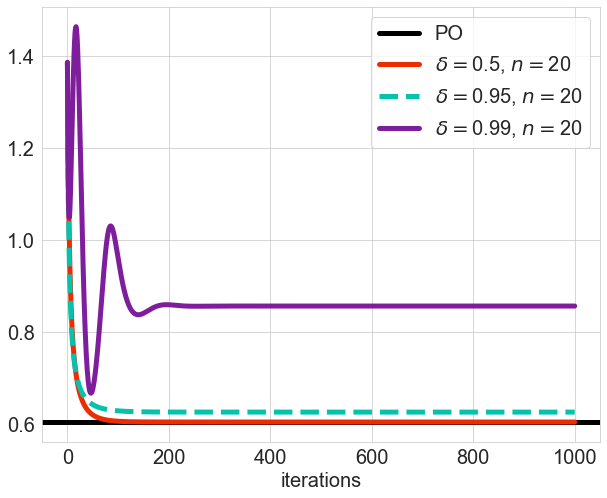

In [290]:
cols=['xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple', 'xkcd:hot pink']
for n_epoch in n_epochs:
    plt.figure(figsize=(10,8))
    plt.axhline(y=loss_final, color='k', linewidth=5, label='PO')
    for i,mixing in enumerate(deltas):
        if i==1:
            ls='--'
        else:
            ls='-'
        plt.plot(losses[(mixing,n_epoch)], label=r'$\delta=${}, $n=${}'.format(mixing,n_epoch), color=cols[i], linewidth=5, ls=ls)
    
    plt.legend(fontsize=20)
    plt.tick_params(labelsize=20)
    plt.xlabel('iterations', fontsize=20)
    for tag in ['png', 'pdf']:
        print('lossconvergence_seed={}_n_epoch={}_new'.format(seed,n_epoch))
        plt.savefig('lossconvergence_seed={}_n_epoch={}_final'.format(seed,n_epoch)+'.'+tag, transparent=True, dpi=300)

### Plotting the classifiers and data distributions

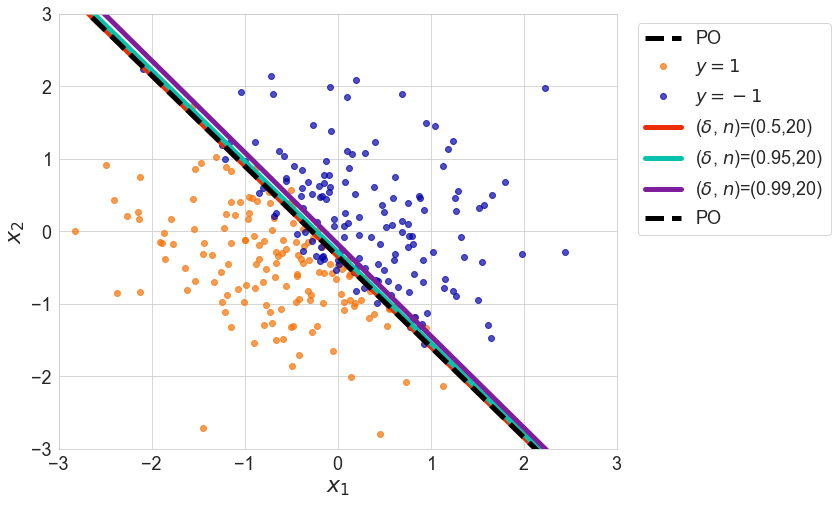

In [294]:
# creates a single plot

def classifier_plotter(X_test,y_test, classifiers, theta_final=theta_final):
    Xp = X_test[np.where(y_test==1)[0],0]
    Yp = X_test[np.where(y_test==1)[0],1]
    Xm = X_test[np.where(y_test==0)[0],0]
    Ym = X_test[np.where(y_test==0)[0],1]
    plt.figure(figsize=(10,8))
    sns.set_style("whitegrid")
    X1_PO, X2_PO=classifier_line(theta_final, bdd=(-3,3))
    cols_=['xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple', 'xkcd:hot pink']
    plt.plot(X1_PO,X2_PO, '--',label='PO', color='xkcd:black', linewidth=5)
    plt.plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', label=r'$y=1$', alpha=0.7)
    plt.plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', label=r'$y=-1$', alpha=0.7)
    #plt.plot(X1_Robust,X2_Robust)
    cols=['xkcd:golden rod', 'xkcd:tomato red', 'xkcd:purple', 'xkcd:hot pink']
    lss=['-','--','-.', ':']
    alphas=[0.6,0.7,0.9,1.0]
    for i,mixing in enumerate(deltas):
        col=cols_[i]
        for ii,n_epoch in enumerate(n_epochs):
            ls=lss[ii]
        
            (X1_PP, X2_PP)=classifiers[(mixing, n_epoch)]
            
            plt.plot(X1_PP,X2_PP, label='($\delta$, $n$)=({},{})'.format(mixing,n_epoch), linewidth=5, color=col, ls=lss[ii], alpha=1.0)
    #plt.plot(X1_PP_d, X2_PP_d)
    #plt.legend(['Data Points +1','Data Points -1','Static', 'Dynamic'])
    plt.plot(X1_PO,X2_PO, '--',label='PO', color='xkcd:black', linewidth=5)
X_perf = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final, strat_features=strat_features,zeta=zeta)
#X_perf_ = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final_d, strat_features=strat_features,zeta=0)
classifier_plotter(X_perf,y_test,classifiers)
plt.legend(fontsize=18, loc=1, bbox_to_anchor=(1.4,1))
plt.tick_params(labelsize=18)
plt.xlabel(r'$x_1$', fontsize=22)
plt.ylabel(r'$x_2$', fontsize=22)
plt.xlim([-3,3])
plt.ylim([-3,3])
for tag in ['pdf','png']:
    plt.savefig('classiferplot_d=2_N=1000_seed={}_nepoch={}_final'.format(seed,n_epoch)+'.'+tag, bbox_inches='tight', transparent=True, dpi=300)

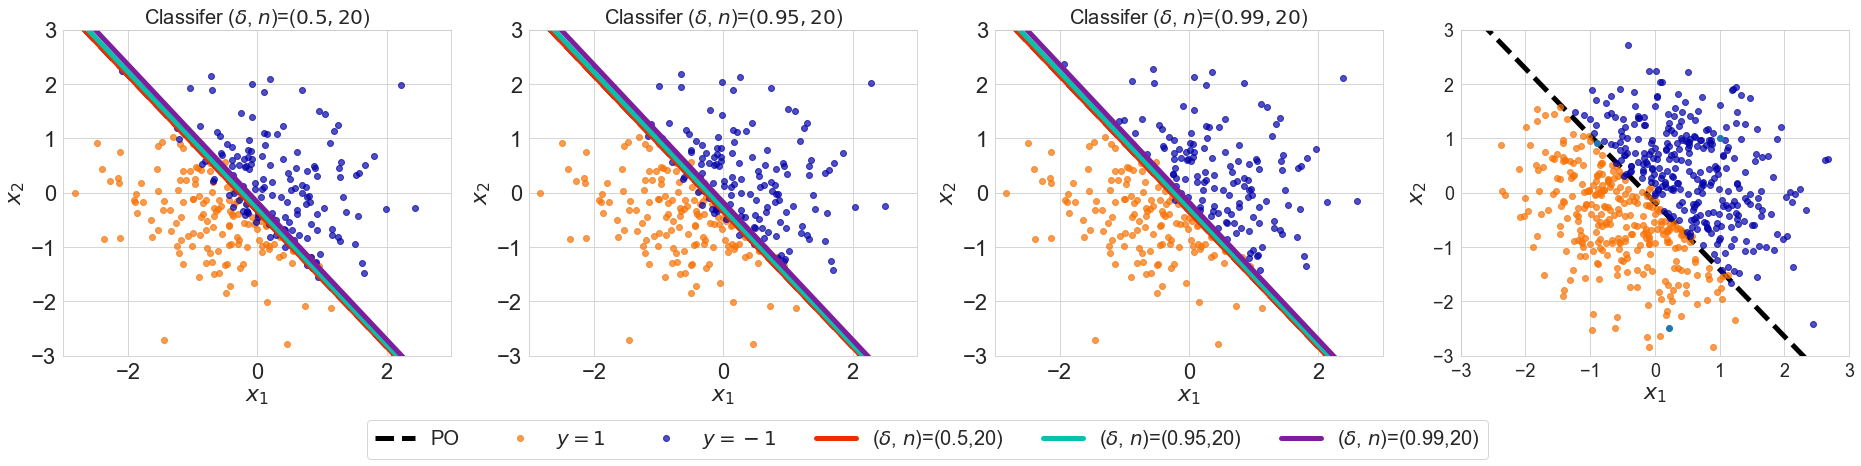

In [360]:
# plots all data distributions induced by the different classifiers with each of the learned classifiers
def classifier_plotter(X_test,y_test, classifiers, theta_final=theta_final, ax=ax):
    Xp = X_test[np.where(y_test==1)[0],0]
    Yp = X_test[np.where(y_test==1)[0],1]
    Xm = X_test[np.where(y_test==0)[0],0]
    Ym = X_test[np.where(y_test==0)[0],1]


    X1_PO, X2_PO=classifier_line(theta_final, bdd=(-3,3))
    cols_=['xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple', 'xkcd:hot pink']
    ax.plot(X1_PO,X2_PO, '--',label='PO', color='xkcd:black', linewidth=5)
    ax.plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', label=r'$y=1$', alpha=0.7)
    ax.plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', label=r'$y=-1$', alpha=0.7)
    #plt.plot(X1_Robust,X2_Robust)
    cols=['xkcd:golden rod', 'xkcd:tomato red', 'xkcd:purple', 'xkcd:hot pink']
    lss=['-','--','-.', ':']
    alphas=[0.6,0.7,0.9,1.0]
    for i,mixing in enumerate(deltas):
        col=cols_[i]
        for ii,n_epoch in enumerate(n_epochs):
            ls=lss[ii]
        
            (X1_PP, X2_PP)=classifiers[(mixing, n_epoch)]
            
            ax.plot(X1_PP,X2_PP, label='($\delta$, $n$)=({},{})'.format(mixing,n_epoch), linewidth=5, color=col, ls=lss[ii], alpha=1.0)
    #plt.plot(X1_PP_d, X2_PP_d)
    #plt.legend(['Data Points +1','Data Points -1','Static', 'Dynamic'])
    ax.plot(X1_PO,X2_PO, '--', color='xkcd:black', linewidth=5)

sns.set_style("whitegrid")    
fig,ax=plt.subplots(nrows=1,ncols=len(deltas)+1, figsize=(32,6), sharey=False)
for n_epoch in n_epochs:
    for i,mixing in enumerate(deltas):    
        X_perf = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final_all[(mixing,n_epoch)], strat_features=strat_features,zeta=zeta)
        ax[i].plot
        #classifier_plotter(X_perf,y_test,classifiers,ax=ax[i])
        
        Xp = X_perf[np.where(y_test==1)[0],0]
        Yp = X_perf[np.where(y_test==1)[0],1]
        Xm = X_perf[np.where(y_test==0)[0],0]
        Ym = X_perf[np.where(y_test==0)[0],1]


        X1_PO, X2_PO=classifier_line(theta_final, bdd=(-3,3))
        cols_=['xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple', 'xkcd:hot pink']
        if i==0:
            ax[i].plot(X1_PO,X2_PO, '--',label='PO', color='xkcd:black', linewidth=5)

            ax[i].plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', label=r'$y=1$', alpha=0.7)
            ax[i].plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', label=r'$y=-1$', alpha=0.7)
        else:
            ax[i].plot(X1_PO,X2_PO, '--', color='xkcd:black', linewidth=5)

            ax[i].plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', alpha=0.7)
            ax[i].plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', alpha=0.7)
        #plt.plot(X1_Robust,X2_Robust)
        cols=['xkcd:golden rod', 'xkcd:tomato red', 'xkcd:purple', 'xkcd:hot pink']
        lss=['-','--','-.', ':']
        alphas=[0.6,0.7,0.9,1.0]
        for ind,mixing in enumerate(deltas):
            col=cols_[ind]
            for ii,n_epoch in enumerate(n_epochs):
                ls=lss[ii]

                (X1_PP, X2_PP)=classifiers[(mixing, n_epoch)]
                if i==0:
                    ax[i].plot(X1_PP,X2_PP, label='($\delta$, $n$)=({},{})'.format(mixing,n_epoch),
                               linewidth=5, color=col, ls=lss[ii], alpha=1.0)
                else:
                    ax[i].plot(X1_PP,X2_PP, 
                               linewidth=5, color=col, ls=lss[ii], alpha=1.0)

        ax[i].tick_params(labelsize=22)
        ax[i].set_xlabel(r'$x_1$', fontsize=22)
        ax[i].set_ylabel(r'$x_2$', fontsize=22)
        ax[i].set_xlim([-3,3])
        ax[i].set_ylim([-3,3])
ax[0].set_title(r'Classifer ($\delta$, $n$)=($0.5,20$)', fontsize=20)
ax[1].set_title(r'Classifer ($\delta$, $n$)=($0.95,20$)', fontsize=20)
ax[2].set_title(r'Classifer ($\delta$, $n$)=($0.99,20$)', fontsize=20)
X_test_=X_train #best_response(X_train ,2*y_train.reshape((N_train, 1))-1,theta_ground_truth, strat_features=strat_features,zeta=zeta)


Xp = X_test_[np.where(y_train==1)[0],0]
Yp = X_test_[np.where(y_train==1)[0],1]
Xm = X_test_[np.where(y_train==0)[0],0]
Ym = X_test_[np.where(y_train==0)[0],1]

X1_PO, X2_PO=classifier_line(theta_ground_truth, bdd=(-3,3))
ax[i+1].plot(X1_PO,X2_PO, color='xkcd:black', linewidth=5, linestyle='--')
ax[i+1].plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', alpha=0.7)
ax[i+1].plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', alpha=0.7)
ax[i+1].plot(X_full_[0], X_full_[1],'.', markersize=12)
ax[i+1].tick_params(labelsize=20)
ax[i+1].set_xlabel(r'$x_1$', fontsize=22)
ax[i+1].set_ylabel(r'$x_2$', fontsize=22)
ax[i+1].set_title(r'', fontsize=20)
ax[i+1].set_xlim([-3,3])
ax[i+1].set_ylim([-3,3])
fig.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=6) 

#plt.legend(fontsize=18, loc=1, bbox_to_anchor=(1.51,1))

plt.tick_params(labelsize=18)



for tag in ['pdf','png']:
    plt.savefig('classiferplot_d=2_N=1000_seed={}_nepoch={}_final'.format(seed,n_epoch)+'.'+tag, bbox_inches='tight', transparent=True, dpi=300)

## Plotting Confusion Matrix

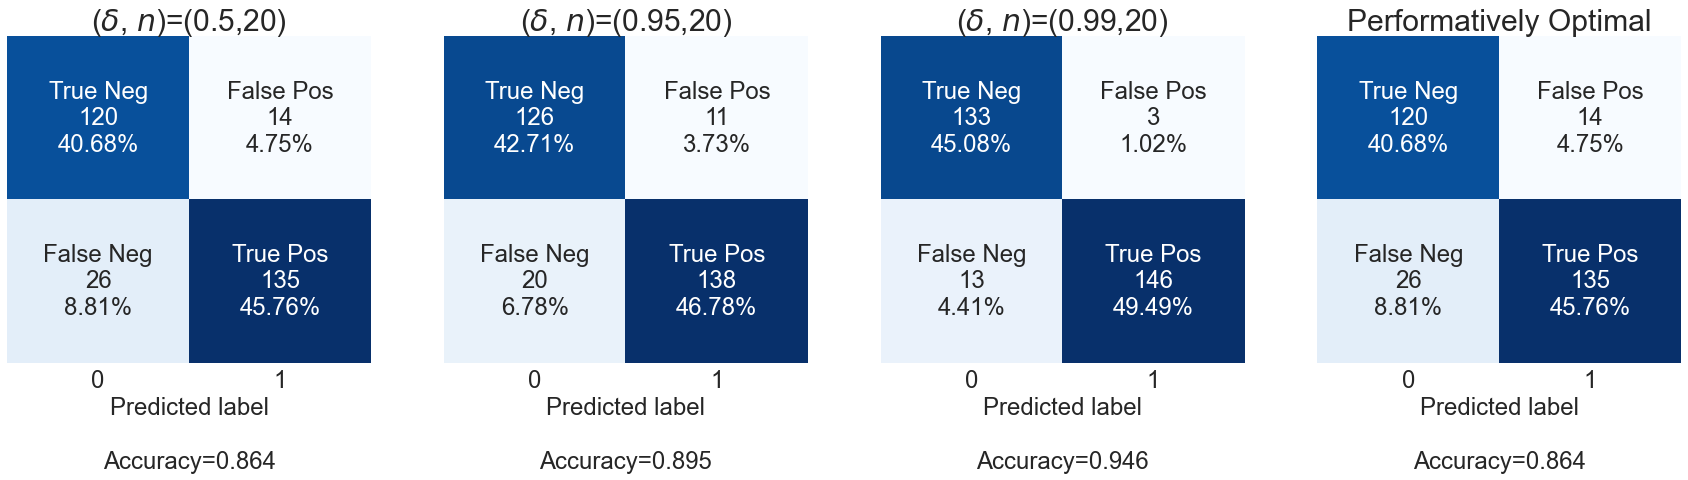

In [359]:



for n_epoch in n_epochs:
    fig,ax=plt.subplots(nrows=1,ncols=len(deltas)+1, figsize=(30,6))
    for i,mixing in enumerate(deltas):
        
        X_perf = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final_all[(mixing,n_epoch)], strat_features=strat_features,zeta=zeta)
        cf_matrix=confusion_matrix((X_perf.dot(theta_final_all[(mixing,n_epoch)]) > 0),y_test)

        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in
                        cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                  zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        mkcfmat(cf_matrix,group_names=group_names, verbose=False, ax=ax[i])
        ax[i].set_title(r'($\delta$, $n$)=({},{})'.format(mixing,n_epoch), fontsize=30)
        
    X_perf = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final, strat_features=strat_features,zeta=zeta)
    cf_matrix=confusion_matrix((X_perf.dot(theta_final) > 0),y_test)
    mkcfmat(cf_matrix,group_names=group_names, verbose=False, ax=ax[i+1])
    ax[i+1].set_title(r'Performatively Optimal', fontsize=30)
    
for tag in ['pdf','png']:
    plt.savefig('confusion_d=2_N=1000_seed={}_nepoch={}_final'.format(seed,n_epoch)+'.'+tag, bbox_inches='tight', transparent=True, dpi=300)